In [1]:
import os
import sys
import joblib

import pandas as pd 
import numpy as np
pd.options.display.max_rows = 100

import imp
import datetime
from tqdm import tqdm

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
plt.style.use('seaborn')
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

In [3]:
import FE_0824 as FE

# Data Load

In [78]:
sale = pd.read_excel(os.path.join('..', '..', 'master', 'Shopping_GG', '0.Data', '01_제공데이터', 'sale_data_v04_0823.xlsx'), encoding="utf-8")
meta = pd.read_excel(os.path.join('..', '..', 'master', 'Shopping_GG', '0.Data', '01_제공데이터', 'sale_meta_v04_0823.xlsx'))
item = pd.read_excel(os.path.join('..', '..', 'master', 'Shopping_GG', '0.Data', '01_제공데이터', 'item_meta_v03_0823.xlsx'))

In [79]:
sale.shape, meta.shape, item.shape

((38309, 15), (2042, 15), (1364, 12))

In [80]:
sale.head()

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,NEW상품코드,NEW상품명,결제방법,단위,브랜드,옵션,종류
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,865.0,테이트 남성 셀린니트 3종,0.0,3종,테이트,NaN,0
1,2019-01-01 06:00:00,NaN,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0,866.0,테이트 여성 셀린니트 3종,0.0,3종,테이트,NaN,0
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0,865.0,테이트 남성 셀린니트 3종,0.0,3종,테이트,NaN,0
3,2019-01-01 06:20:00,NaN,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0,866.0,테이트 여성 셀린니트 3종,0.0,3종,테이트,NaN,0
4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0,865.0,테이트 남성 셀린니트 3종,0.0,3종,테이트,NaN,0


In [81]:
# 무형 데이터 처리 : 동일 상품명으로 채워줌 
sale["NEW상품명"] = sale["NEW상품명"].fillna(sale["상품명"])

# Feature Engineering

In [82]:
imp.reload(FE)

<module 'FE_0824' from 'C:\\Users\\LG\\Jupyter Notebook\\bigcontest\\git\\Shopping_GG\\Modeling\\FE_0824.py'>

In [83]:
sale2 = sale.copy()

In [84]:
# 재빈
sale2 = FE.FE_product_timelag_JB.broadcast_count(sale2)
sale2 = FE.FE_product_timelag_JB.sales_count(sale2)

In [85]:
# 예진
sale2 = FE.FE_sold_out_fill_time_YJ.sold_out_fill_time(sale2)

In [86]:
# 진석 
sale2 = FE.FE_dateprice_JS.preprocessing(sale2)

연도입력
2019


In [15]:
sale2.isnull().sum()

방송일시                  0
노출(분)                 0
마더코드                  0
상품코드                  0
상품명                   0
상품군                   0
판매단가                  0
취급액                2930
NEW상품코드             937
NEW상품명                0
결제방법                937
단위                15919
브랜드                5243
옵션                34169
종류                15565
상품노출횟수                0
브랜드노출횟수               0
상품총판매횟수               0
브랜드총판매횟수              0
조기매진                  0
locdate               0
isHoliday         36482
방송월                   0
방송시간(시간)              0
방송시간(분)               0
평일여부                  0
방송시간대                 0
계절                    0
분기                    0
성별                    0
상품군_최고판매단가          937
상품군_최저판매단가          937
상품군_평균판매단가          937
상품군_중간판매단가          937
상품군_최고-최저           937
상품군_표준편차            937
상품군_분산              937
마더코드_최고판매단가         937
마더코드_최저판매단가         937
마더코드_평균판매단가         937
마더코드_최고-최저          937
마더코드_분산         

## Preprocessing

### isHoliday

In [16]:
sale2["isHoliday"].value_counts()

Y    1827
Name: isHoliday, dtype: int64

In [87]:
sale2["isHoliday"] = sale2["isHoliday"].map(lambda x : 1 if x == 'Y' else 0)

In [88]:
sale2["isHoliday"].value_counts()

0    36482
1     1827
Name: isHoliday, dtype: int64

### 무형 상품군 제외 

In [89]:
sale2 = sale2.loc[sale2["상품군"] != "무형"]
sale2.shape

(37372, 60)

### 취급액 
* 이거때문에 MAPE값 크게 나오는 것 같은데 ... 

In [90]:
sale2["취급액"] = sale2["취급액"].fillna(1e-5)

### 상품군&브랜드 결측값 

In [91]:
sale2 = sale2.fillna(0)

### 더미화 

In [22]:
category = ['결제방법', '상품군_가격대', '전체_가격대', '상품군', '방송시간(시간)']

drop_columns = ['방송일시', '상품명', '마더코드', '상품코드', 
                'NEW상품코드', 'NEW상품명', '옵션', '종류', '단위', '브랜드', 'locdate',                 
                '취급액']

In [92]:
for c in category:
    sale2[c] = sale2[c].astype(str)

In [93]:
y = sale2['취급액']
temp = sale2[drop_columns]
data= sale2.drop(drop_columns, axis = 1)

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37372 entries, 0 to 38303
Data columns (total 48 columns):
노출(분)             37372 non-null float64
상품군               37372 non-null object
판매단가              37372 non-null int64
결제방법              37372 non-null object
상품노출횟수            37372 non-null float64
브랜드노출횟수           37372 non-null float64
상품총판매횟수           37372 non-null int64
브랜드총판매횟수          37372 non-null float64
조기매진              37372 non-null int64
isHoliday         37372 non-null int64
방송월               37372 non-null int64
방송시간(시간)          37372 non-null object
방송시간(분)           37372 non-null int64
평일여부              37372 non-null int64
방송시간대             37372 non-null object
계절                37372 non-null object
분기                37372 non-null object
성별                37372 non-null int64
상품군_최고판매단가        37372 non-null float64
상품군_최저판매단가        37372 non-null float64
상품군_평균판매단가        37372 non-null float64
상품군_중간판매단가        37372 non-null float64
상품군_최고-최저  

In [94]:
X = pd.get_dummies(data)

In [95]:
X.shape, y.shape

((37372, 99), (37372,))

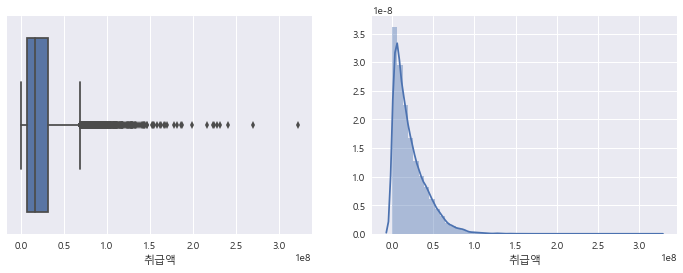

In [37]:
figure, (ax1, ax2) = plt.subplots(ncols=2)
figure.set_size_inches(12,4)

sns.boxplot(y, ax=ax1)
sns.distplot(y, ax=ax2)

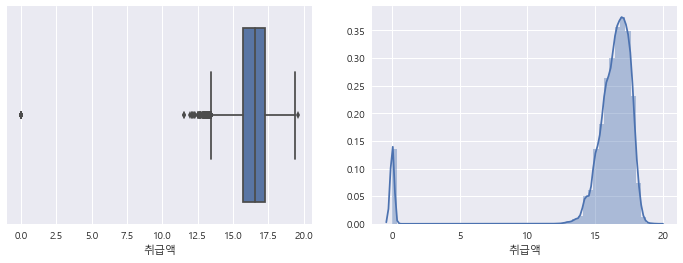

In [38]:
# log변환 후의 y  
figure, (ax1, ax2) = plt.subplots(ncols=2)
figure.set_size_inches(12,4)

sns.boxplot(np.log1p(y), ax=ax1)
sns.distplot(np.log1p(y), ax=ax2)

In [41]:
# 주문량 0... 어떻게 해야 하나...? 어차피 평가지표 값은 크게 나올 수 밖에 없는 것 같은데 
sale2.loc[sale2["취급액"] < 1].shape 

(1993, 60)

## Modeling

In [31]:
import random

In [30]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [32]:
# 여기에있는거 1도 안씀 나중에 써보겟삼 
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import LinearSVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [33]:
import warnings
warnings.filterwarnings(action='ignore')

### 평가지표 : MAPE

In [42]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### xgboost 

In [45]:
import xgboost as xgb
model = xgb.XGBRegressor()

In [46]:
xgb_params = {'min_child_weight': 1, 'eta': 0.5, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1, 
            'objective': 'reg:linear'}

In [47]:
preds = []
for i in range(1,13):
    # 한달에서도 랜덤 샘플 반 뽑기
    test_idx = random.sample(list(X[X['방송월'] == i].index), int(len(X[X['방송월'] == i]) / 2))
    train_idx = set(X.index) - set(test_idx)
    
    train = X.loc[train_idx]
    test = X.loc[test_idx]
    y_test = y.loc[test_idx]
    
    x_train = train[train['방송월'] != i]
    y_train = y.loc[train[train['방송월'] != i].index]
    
    x_val = train[train['방송월'] == i]
    y_val = y.loc[train[train['방송월'] == i].index]
    
    dtrain = xgb.DMatrix(x_train, label = y_train)
    dvalid = xgb.DMatrix(x_val, label = y_val)
    
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
    
    model = xgb.train(xgb_params, dtrain, 10000, watchlist, early_stopping_rounds=100, verbose_eval=10)
    
    dtest = xgb.DMatrix(test)
    pred = model.predict(dtest)

    preds.append(mean_absolute_percentage_error(y_test, pred))
    print(preds)
print(np.mean(preds))

[0]	train-rmse:1.97804e+07	valid-rmse:2.22883e+07
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[10]	train-rmse:1.09885e+07	valid-rmse:1.28405e+07
[20]	train-rmse:9.98568e+06	valid-rmse:1.2654e+07
[30]	train-rmse:9.29555e+06	valid-rmse:1.22916e+07
[40]	train-rmse:8.78392e+06	valid-rmse:1.21417e+07
[50]	train-rmse:8.36986e+06	valid-rmse:1.23432e+07
[60]	train-rmse:8.12146e+06	valid-rmse:1.22517e+07
[70]	train-rmse:7.85121e+06	valid-rmse:1.21662e+07
[80]	train-rmse:7.66711e+06	valid-rmse:1.2154e+07
[90]	train-rmse:7.46322e+06	valid-rmse:1.21748e+07
[100]	train-rmse:7.30667e+06	valid-rmse:1.23088e+07
[110]	train-rmse:7.1669e+06	valid-rmse:1.22423e+07
[120]	train-rmse:7.03035e+06	valid-rmse:1.23382e+07
[130]	train-rmse:6.91028e+06	valid-rmse:1.22934e+07
[140]	train-rmse:6.78776e+06	valid-rmse:1.22216e+07
[150]	train-rmse:6.7061e+06	valid-rmse:1.22371e+07
[160]	train-rmse:6.62035e+06	valid-rm

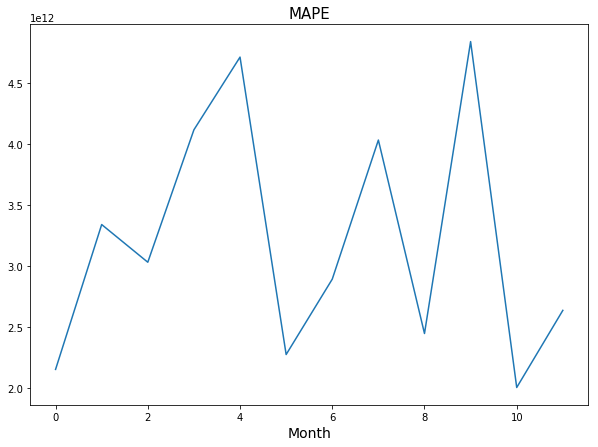

In [108]:
plt.figure(figsize = (10, 7))
plt.plot(preds)
plt.xlabel('Month', fontsize = 14)
plt.title('MAPE', fontsize = 15)
plt.show()

### 취급액 0 데이터가 없을 때 

In [96]:
sale3 = sale2.loc[sale2["취급액"] > 1]
sale3.shape

(35379, 60)

In [97]:
y = sale3['취급액']
temp2 = sale3[drop_columns]
data2 = sale3.drop(drop_columns, axis = 1)

In [98]:
X = pd.get_dummies(data2)

In [51]:
preds = []
for i in range(1,13):
    # 한달에서도 랜덤 샘플 반 뽑기
    test_idx = random.sample(list(X[X['방송월'] == i].index), int(len(X[X['방송월'] == i]) / 2))
    train_idx = set(X.index) - set(test_idx)
    
    train = X.loc[train_idx]
    test = X.loc[test_idx]
    y_test = y.loc[test_idx]
    
    x_train = train[train['방송월'] != i]
    y_train = y.loc[train[train['방송월'] != i].index]
    
    x_val = train[train['방송월'] == i]
    y_val = y.loc[train[train['방송월'] == i].index]
    
    dtrain = xgb.DMatrix(x_train, label = y_train)
    dvalid = xgb.DMatrix(x_val, label = y_val)
    
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
    
    model = xgb.train(xgb_params, dtrain, 10000, watchlist, early_stopping_rounds=100, verbose_eval=10)
    
    dtest = xgb.DMatrix(test)
    pred = model.predict(dtest)

    preds.append(mean_absolute_percentage_error(y_test, pred))
    print(preds)
print(np.mean(preds))

[0]	train-rmse:2.01876e+07	valid-rmse:2.15344e+07
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[10]	train-rmse:1.11997e+07	valid-rmse:1.22234e+07
[20]	train-rmse:9.97437e+06	valid-rmse:1.18427e+07
[30]	train-rmse:9.29568e+06	valid-rmse:1.15646e+07
[40]	train-rmse:8.90012e+06	valid-rmse:1.15086e+07
[50]	train-rmse:8.46478e+06	valid-rmse:1.15617e+07
[60]	train-rmse:8.17739e+06	valid-rmse:1.15682e+07
[70]	train-rmse:7.85397e+06	valid-rmse:1.14265e+07
[80]	train-rmse:7.62415e+06	valid-rmse:1.1514e+07
[90]	train-rmse:7.43971e+06	valid-rmse:1.15195e+07
[100]	train-rmse:7.27566e+06	valid-rmse:1.14922e+07
[110]	train-rmse:7.13288e+06	valid-rmse:1.14486e+07
[120]	train-rmse:6.97198e+06	valid-rmse:1.15519e+07
[130]	train-rmse:6.85016e+06	valid-rmse:1.15362e+07
[140]	train-rmse:6.74241e+06	valid-rmse:1.157e+07
[150]	train-rmse:6.64713e+06	valid-rmse:1.15471e+07
[160]	train-rmse:6.54269e+06	valid-r

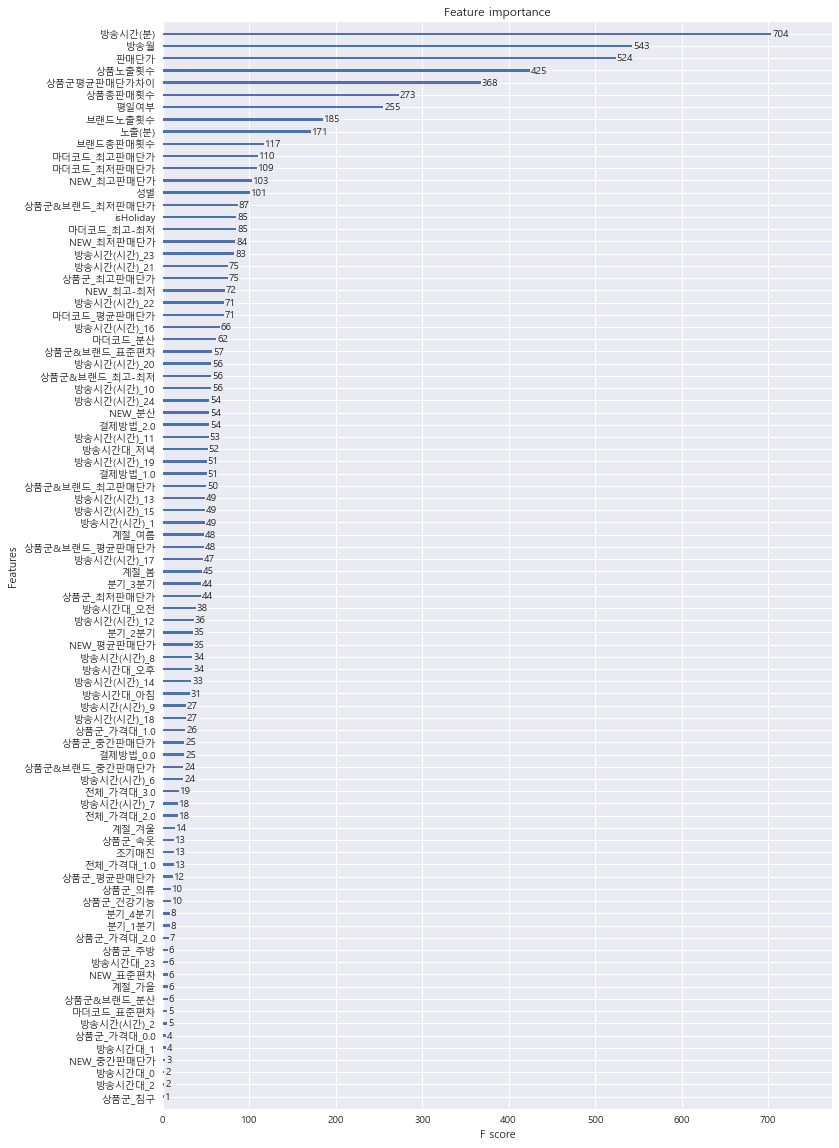

In [64]:
# 가장 마지막 fold에서의 feature importance (12월)
from xgboost import plot_importance

plt.rcParams["figure.figsize"] = (12, 20)
plot_importance(model, )

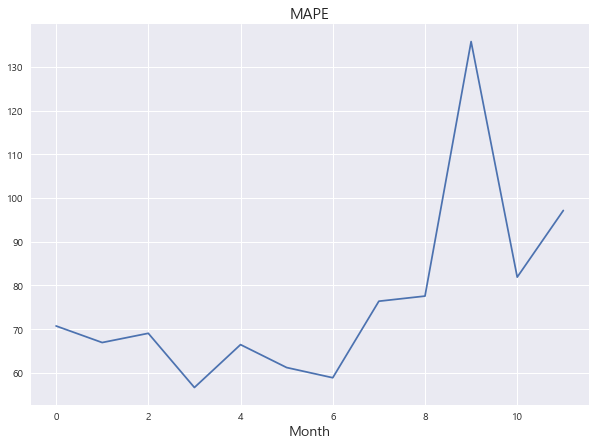

In [63]:
plt.figure(figsize = (10, 7))
plt.plot(preds)
plt.xlabel('Month', fontsize = 14)
plt.title('MAPE', fontsize = 15)
plt.show()

* MAPE는 y와 log(y) 사이에 큰 차이는 없는데, 
* 취급액이 0 값인게 들어가 버리면 진짜...... 값이 너무 커짐      
  (그럴 수 밖에 없는게, 만약 0인걸 0으로 예측을 못하고 조금이라도 값이 들어가 버리게 되면, 퍼센트 자체가 커질 수 밖에 없는 것 같음) 
* 취급액 0인건 따로 뽑아서 나중에 값을 채워넣는 방식으로 진행해야 하나...? 

### LGBM : 겁나 이상하게 ㄴㅏ와 ~ 

In [151]:
import lightgbm as lgb

In [217]:
lgb_params = {'learning_rate': 0.03, 'max_depth' : 16, 'objective': 'regression', 'metric': 'mape', 'is_training_metric': True,
              'min_child_samples' : 40, 'n_estimators' : 2000, 'num_leaves' : 8, 'subsample' : 0.6}

In [211]:
y = sale3['취급액']
X = sale3.drop(drop_columns, axis = 1)

In [212]:
X = pd.get_dummies(data)

In [213]:
# 로그변환 취한 값이 훨씬 작게 나옴 ! 
y = np.log1p(y)

In [214]:
X.shape , y.shape

((37372, 99), (35379,))

In [215]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [236]:
preds = []
idx = [] 
feat_imp = [0] * len(X.columns)

final_y = [] # 최종 예측한 값 

for i in range(1,13):
    # 한달에서도 랜덤 샘플 반 뽑기
    test_idx = random.sample(list(X[X['방송월'] == i].index), int(len(X[X['방송월'] == i]) / 2))
    train_idx = set(X.index) - set(test_idx)
    
    train = X.loc[train_idx]
    test = X.loc[test_idx]
    y_test = y.loc[test_idx]
    
    x_train = train[train['방송월'] != i]
    y_train = y.loc[train[train['방송월'] != i].index]
    
    x_val = train[train['방송월'] == i]
    y_val = y.loc[train[train['방송월'] == i].index]
    
    train_T = lgb.Dataset(x_train.values, label=y_train.values) 
    val_T = lgb.Dataset(x_val.values, label=y_val.values)
    
    
    model2 = lgb.train(lgb_params, train_T, 3000, valid_sets = val_T, verbose_eval=500, early_stopping_rounds=500)
    lgb_pred = model2.predict(test.values)

    
    preds.append(np.mean(np.abs((y_test.values - lgb_pred) / y_test.values)) * 100)
    feat_imp += model2.feature_importance()
    
    final_y.append(lgb_pred)
    idx.append(test_idx)
    
    print(preds)
    
print(np.mean(preds))

Training until validation scores don't improve for 500 rounds
[500]	valid_0's mape: 0.458906
Early stopping, best iteration is:
[286]	valid_0's mape: 0.4556
[nan]
Training until validation scores don't improve for 500 rounds
[500]	valid_0's mape: 0.614682
Early stopping, best iteration is:
[325]	valid_0's mape: 0.607672
[nan, nan]
Training until validation scores don't improve for 500 rounds
[500]	valid_0's mape: 0.573554
[1000]	valid_0's mape: 0.560067
[1500]	valid_0's mape: 0.546975
[2000]	valid_0's mape: 0.541765
Did not meet early stopping. Best iteration is:
[1958]	valid_0's mape: 0.541604
[nan, nan, nan]
Training until validation scores don't improve for 500 rounds
[500]	valid_0's mape: 0.712839
[1000]	valid_0's mape: 0.686428
[1500]	valid_0's mape: 0.673494
[2000]	valid_0's mape: 0.671333
Did not meet early stopping. Best iteration is:
[1652]	valid_0's mape: 0.670995
[nan, nan, nan, nan]
Training until validation scores don't improve for 500 rounds
[500]	valid_0's mape: 0.78777


nan ? ㅎㅎㅎ 왜 여기서 출력이 안되는거징... 별별 방법 해봐도 안됨 ㅜㅜ 

In [238]:
# i 월을 validation set으로 두고 계산한 결과 
for i in range(len(final_y)) :      
    print(i+1, "월 계산 결과 : ", np.mean(np.abs((y.loc[idx[i]] - final_y[i]) / y.loc[idx[i]])) * 100)

1 월 계산 결과 :  4.938414696452168
2 월 계산 결과 :  5.349659653453789
3 월 계산 결과 :  5.628131146667971
4 월 계산 결과 :  6.87777396175399
5 월 계산 결과 :  7.051476776716369
6 월 계산 결과 :  5.1729183875928575
7 월 계산 결과 :  6.048275281964641
8 월 계산 결과 :  5.637896305262689
9 월 계산 결과 :  5.3025082904344165
10 월 계산 결과 :  4.611281875377116
11 월 계산 결과 :  5.40467848454861
12 월 계산 결과 :  5.034035073515877


In [240]:
np.mean([np.mean(np.abs((y.loc[idx[i]] - final_y[i]) / y.loc[idx[i]])) * 100 for i in range(len(final_y))])

5.588087494478375

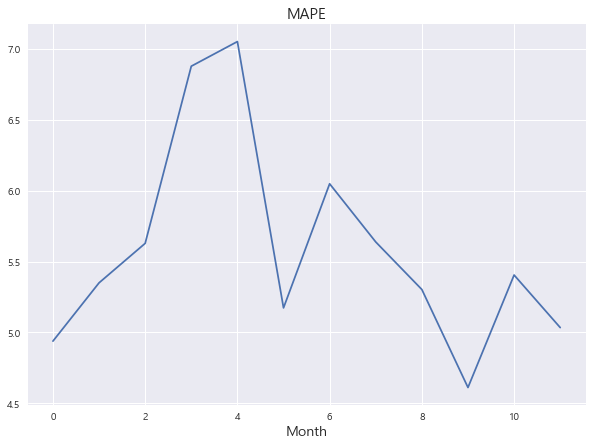

In [241]:
plt.figure(figsize = (10, 7))
plt.plot([np.mean(np.abs((y.loc[idx[i]] - final_y[i]) / y.loc[idx[i]])) * 100 for i in range(len(final_y))])
plt.xlabel('Month', fontsize = 14)
plt.title('MAPE', fontsize = 15)
plt.show()

주의 : 이건 log(y) 취한 값이라는 것 ... 

In [242]:
feature_importance = pd.DataFrame({ 'feature' : X.columns, 
                                   'importance' : feat_imp / 12}).sort_values(by='importance', ascending=False)

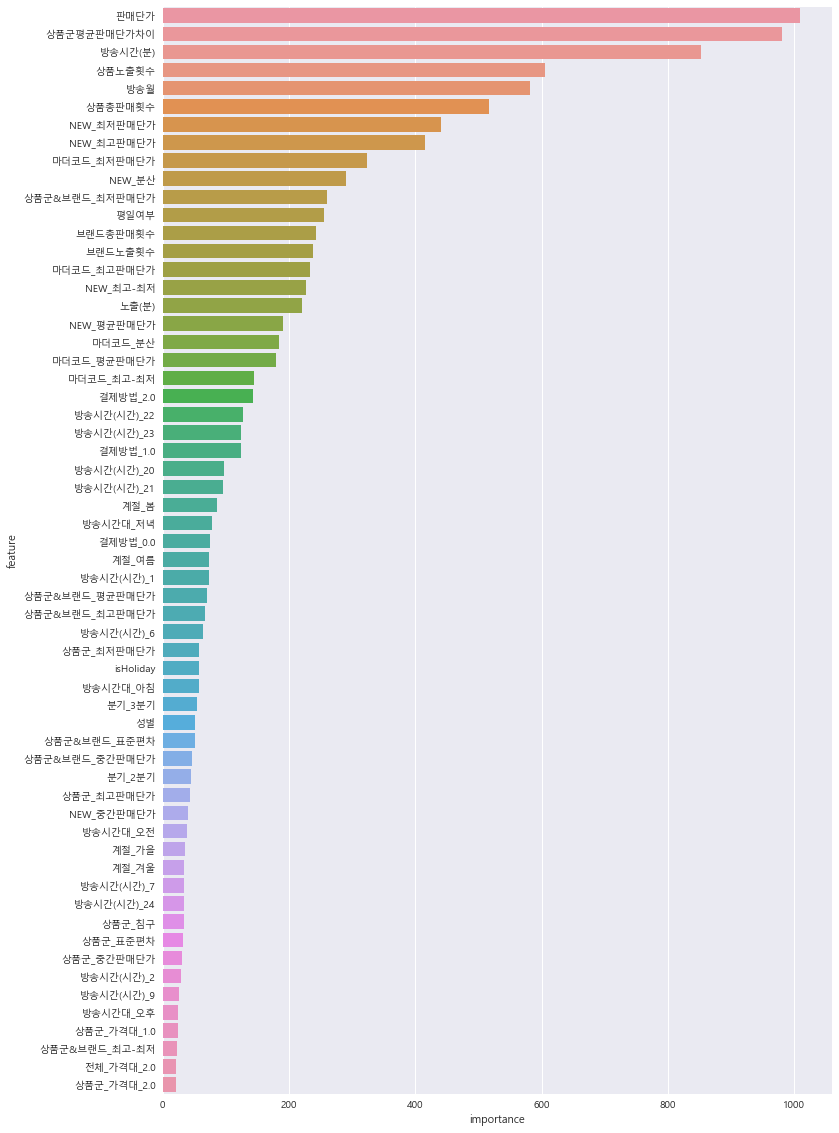

In [243]:
fig, ax = plt.subplots(figsize=(12,20))

sns.barplot(
    data= feature_importance[feature_importance["importance"] > 20],
    x= "importance",
    y= "feature"
)

* lgbm 일단 저렇게 돌렸는데 결과가 이상하게 나와서 넘 당황스러움...... (수작업 해뜸...)
* 다시 돌리겟슴돵...... 

* 글고 우리 피쳐 잘 붙이고 있는듯 ..? 결과는 좀 글킨 한데 importance 보면 우리가 만든 피쳐가 순위가 높높 ~! 

* 이렇게 말고 다른 코드를 찾아서 잘 돌아가게끔 할게용..... (갓윤수님 코드 참고해 보겟슴..)